- Calculate and plot the Theil-Sen slope map for GRACE/GRACE-FO TWS annomaly. 
- For mascon and harmonic solution.
- Uncertainty calculations and plots

In [23]:
%reset -f
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import theilslopes
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

%matplotlib inline

In [24]:
# Import data
Iwe_Grace = xr.open_mfdataset('/home/bauer013/ls/data/TELLUS_GRAC_L3_JPL_RL06_LND_v04_new/*.nc', engine='netcdf4', chunks=None)
Iwe_GraceFO = xr.open_mfdataset('/home/bauer013/ls/data/TELLUS_GRFO_L3_JPL_RL06.1_LND_v04_old/*.nc', engine='netcdf4', chunks=None)
ocean_mask = xr.open_dataset('/home/bauer013/ls/data/IMERG_land_sea_mask.nc')
grace_mascon = xr.open_dataset('/home/bauer013/ls/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202305.GLO.RL06.1M.MSCNv03CRI.nc')

In [25]:
#Pre-Prossecing for JPL Harmonic Solution
# choose Lat and lon range
lon_min,lon_max = 60,349
lat_min,lat_max = 35,72
Iwe_Grace = Iwe_Grace.sel(lon=(Iwe_Grace['lon'] < lon_min) | (Iwe_Grace['lon'] >lon_max))
Iwe_Grace = Iwe_Grace.sel(lat=(Iwe_Grace['lat'] > lat_min) & (Iwe_Grace['lat'] < lat_max ))
Iwe_GraceFO = Iwe_GraceFO.sel(lon=(Iwe_GraceFO['lon'] < lon_min) | (Iwe_GraceFO['lon'] > lon_max))
Iwe_GraceFO = Iwe_GraceFO.sel(lat=(Iwe_GraceFO['lat'] > lat_min) & (Iwe_GraceFO['lat'] < lat_max))

#Take the annual mean and group the grace and GraceFO togheter
annual_meanGRACE = Iwe_Grace.groupby('time.year').mean(dim='time')
annual_meanGRACE['lat'] = np.round(annual_meanGRACE['lat'], decimals=1)
annual_meanGRACE['lon'] = np.round(annual_meanGRACE['lon'], decimals=1)
annual_meanGRACEFO =  Iwe_GraceFO.groupby('time.year').mean(dim='time')
IWE_grace_graceFO = xr.concat([annual_meanGRACE, annual_meanGRACEFO], dim='year')

#Step for faster calculation of theil-sen slope in the loop
lwe_thickness_array = IWE_grace_graceFO['lwe_thickness'].values
lwe_thickness_dims = IWE_grace_graceFO['lwe_thickness'].dims
IWE_grace_graceFO['lwe_thickness'] = (lwe_thickness_dims, lwe_thickness_array)
uncertainty_array = IWE_grace_graceFO['uncertainty'].values
uncertainty_dims = IWE_grace_graceFO['uncertainty'].dims
IWE_grace_graceFO['uncertainty'] = (uncertainty_dims, uncertainty_array)

#Chose the time period
IWE_grace_graceFO = IWE_grace_graceFO.drop_sel(year=[2020,2021,2022,2023])

#create new dataset for slope map
lon_range = Iwe_Grace['lon'].values
lat_range = Iwe_Grace['lat'].values
TS_slope= xr.Dataset(
    {'slope': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
    'intercept': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
    'low_slope': (['lat', 'lon'],  np.empty((len(lat_range), len(lon_range)))),
    'high_slope': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range))))},
    coords={'lat': lat_range, 'lon': lon_range},
)


In [6]:
#Pre-Prossecing for Mascon JPL
# choose Lat and lon range mascon
lon_min,lon_max = 60,349
lat_min,lat_max = 35,72
grace_mascon = grace_mascon.sel(lon=(grace_mascon['lon'] < lon_min) | (grace_mascon['lon'] > lon_max))
grace_mascon = grace_mascon.sel(lat=(grace_mascon['lat'] > lat_min) & (grace_mascon['lat'] < lat_max))

#Take annual mean
IWE_grace_mascon = grace_mascon.groupby('time.year').mean(dim='time')
IWE_grace_mascon['lat'] = np.round(IWE_grace_mascon['lat'], decimals=2)
IWE_grace_mascon['lon'] = np.round(IWE_grace_mascon['lon'], decimals=2)

#Step for faster calculation of theil-sen slope
lwe_thickness_array = IWE_grace_mascon['lwe_thickness'].values
lwe_thickness_dims = IWE_grace_mascon['lwe_thickness'].dims
IWE_grace_mascon['lwe_thickness'] = (lwe_thickness_dims, lwe_thickness_array)

#choose time period
IWE_grace_mascon = IWE_grace_mascon.drop_sel(year=[2020, 2021, 2022, 2023])

#create new dataset for slope map
lon_range = grace_mascon['lon'].values
lat_range = grace_mascon['lat'].values
TS_slope= xr.Dataset(
    {'slope': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
    'intercept': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range)))),
    'low_slope': (['lat', 'lon'],  np.empty((len(lat_range), len(lon_range)))),
    'high_slope': (['lat', 'lon'], np.empty((len(lat_range), len(lon_range))))},
    coords={'lat': lat_range, 'lon': lon_range},
)

In [9]:
#uncertainty analysis
uncertainty_mean_grace = IWE_grace_graceFO['uncertainty'].mean(dim='year')
lwe_thickness_max_difference = IWE_grace_graceFO['lwe_thickness'].max(dim='year') - IWE_grace_graceFO['lwe_thickness'].min(dim='year')
uncertainty_ratio = uncertainty_mean_grace / lwe_thickness_max_difference


In [26]:
#Apply a ocean mask (for harmonic solution)
#ocean mask Data from https://gpm.nasa.gov/data/directory/imerg-land-sea-mask-netcdf 23.04.2024
ocean_mask = ocean_mask.sel(lon=slice(0, 360))
ocean_mask = ocean_mask.sel(lon=(ocean_mask['lon'] < 60) | (ocean_mask['lon'] > 349))
ocean_mask = ocean_mask.sel(lat=(ocean_mask['lat'] > 35) & (ocean_mask['lat'] < 72 ))
ocean_mask = ocean_mask.coarsen(lon=10, lat=10).mean()
ocean_mask  = ocean_mask.expand_dims({'year': IWE_grace_graceFO.year}, axis=0)
# adjust parameter. Which percentage needs to be water
ocean_mask = ocean_mask['landseamask'] > 75 # Typical percentage thresholds used to define sea are 100% (strictly open water) or 75% (including sea-ward coast areas)
ocean_mask['lat'] = np.round(ocean_mask['lat'], decimals=1)
ocean_mask['lon'] = np.round(ocean_mask['lon'], decimals=1)
IWE_grace_graceFO['lwe_thickness'] = IWE_grace_graceFO['lwe_thickness'].where(~ocean_mask, np.nan)

In [27]:
#calculate slope
for lon in lon_range:
  for lat in lat_range:
    IWE_grace_graceFOr = IWE_grace_graceFO['lwe_thickness'].sel(lon=lon, lat=lat, method='nearest') #Harmonic solution
    #IWE_grace_graceFOr = IWE_grace_mascon['lwe_thickness'].sel(lon=lon, lat=lat, method='nearest')  #Mascon Solution
    slope, intercept, low_slope, high_slope = theilslopes(IWE_grace_graceFOr.values, IWE_grace_graceFOr['year'].values, alpha=0.95, method='separate')
    TS_slope['slope'].loc[{'lat': lat, 'lon': lon}] = slope
    TS_slope['intercept'].loc[{'lat': lat, 'lon': lon}] = intercept
    TS_slope['low_slope'].loc[{'lat': lat, 'lon': lon}] = low_slope
    TS_slope['high_slope'].loc[{'lat': lat, 'lon': lon}] = high_slope


In [29]:
# Reorder longitudes (needed to plot)
lon_value = 60 #120 for mascon , 60 Harmonic solution
TS_slope['lon'] = (TS_slope['lon'] + 180) % 360 - 180
TS_slope['lon'] = np.concatenate([TS_slope['lon'].values[lon_value:], TS_slope['lon'].values[:lon_value]])
slope_reordered = np.concatenate([TS_slope['slope'].values[:, lon_value:], TS_slope['slope'].values[:, :lon_value]], axis=1)
intercept_reordered = np.concatenate([TS_slope['intercept'].values[:, lon_value:], TS_slope['intercept'].values[:, :lon_value]], axis=1)
TS_var3_reordered = np.concatenate([TS_slope['low_slope'].values[:, lon_value:], TS_slope['low_slope'].values[:, :lon_value]], axis=1)
TS_var4_reordered = np.concatenate([TS_slope['high_slope'].values[:, lon_value:], TS_slope['high_slope'].values[:, :lon_value]], axis=1)
TS_slope['slope'] = xr.DataArray(slope_reordered, dims=('lat', 'lon'), coords={'lat': TS_slope['lat'], 'lon': TS_slope['lon']})
TS_slope['intercept'] = xr.DataArray(intercept_reordered, dims=('lat', 'lon'), coords={'lat': TS_slope['lat'], 'lon': TS_slope['lon']})
TS_slope['low_slope'] = xr.DataArray(TS_var3_reordered, dims=('lat', 'lon'), coords={'lat': TS_slope['lat'], 'lon': TS_slope['lon']})
TS_slope['high_slope'] = xr.DataArray(TS_var4_reordered, dims=('lat', 'lon'), coords={'lat': TS_slope['lat'], 'lon': TS_slope['lon']})

/home/bauer013/miniconda3/envs/grace_env/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: shading value 'none' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  result = super().pcolormesh(*args, **kwargs)


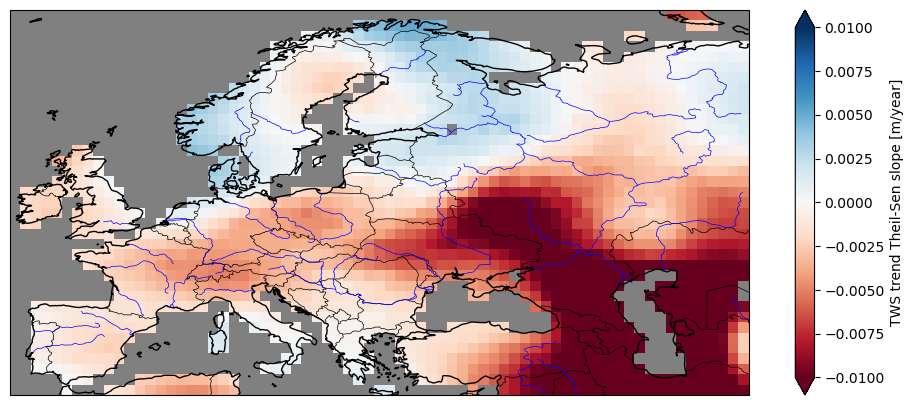

In [32]:
# PLot slope map
# Create a Plate Carrée projection axis
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('RdBu_r')
cmap = cmap.reversed()
vmin, vmax = -0.01, 0.01
# Plot the slope
c  = ax.pcolormesh(TS_slope['lon'].values, TS_slope['lat'].values, TS_slope['slope'].values, vmin=vmin, vmax=vmax, cmap=cmap,transform=ccrs.PlateCarree(), shading='none')
cmap.set_bad(color='grey', alpha=1.0) 
# Add coastlines for reference
ax.coastlines()
countries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', edgecolor='black', facecolor='none')
rivers = NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', edgecolor='blue', facecolor='none')

ax.add_feature(countries, linestyle='-', linewidth=0.5)
ax.add_feature(rivers, linestyle='-', linewidth=0.5)


# Add colorbar
cbar = plt.colorbar(c, ax=ax, label='TWS trend Theil-Sen slope [m year-1]',  extend='both', orientation='horizontal')
cbar.ax.set_position([0.2, 0.27, 0.6, 0.03]) 
# Show the plot
plt.show()

In [22]:
# PLot slope map reorder
uncertainty_ratio['lon'] = (uncertainty_ratio['lon'] + 180) % 360 - 180
uncertainty_ratio['lon'] = np.concatenate([uncertainty_ratio['lon'].values[60:], uncertainty_ratio['lon'].values[:60]])
uncertainty_ratio_reordered = np.concatenate([uncertainty_ratio.values[:, 60:], uncertainty_ratio.values[:, :60]], axis=1)
uncertainty_ratio_da = xr.DataArray(uncertainty_ratio_reordered, dims=('lat', 'lon'), coords={'lat': TS_slope['lat'], 'lon': TS_slope['lon']})
uncertainty_ratio.values = uncertainty_ratio_da


/home/bauer013/miniconda3/envs/grace_env/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: shading value 'none' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  result = super().pcolormesh(*args, **kwargs)


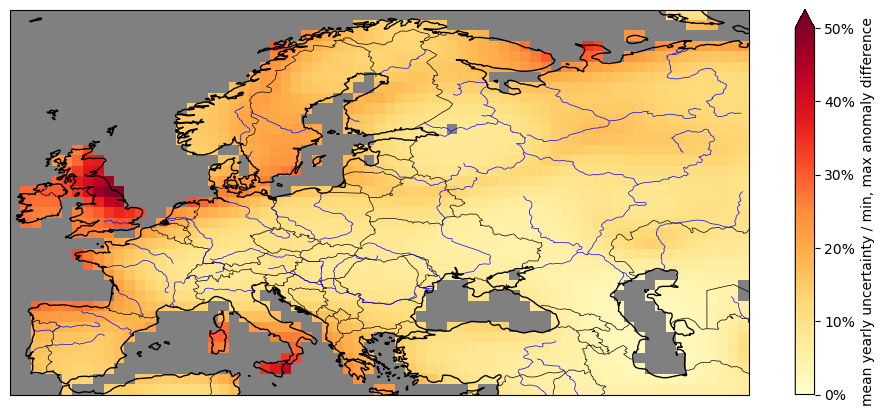

In [27]:

# Create a Plate Carrée projection axis
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('YlOrRd')
vmin, vmax = 0, 0.5

# Plot the slope
c  = ax.pcolormesh(uncertainty_ratio['lon'].values, uncertainty_ratio['lat'].values, uncertainty_ratio.values, vmin=vmin, vmax=vmax, cmap=cmap,transform=ccrs.PlateCarree(), shading='none')

cmap.set_bad(color='grey', alpha=1.0) 
# Add coastlines for reference
ax.coastlines()
countries = NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='50m', edgecolor='black', facecolor='none')
rivers = NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='50m', edgecolor='blue', facecolor='none')

ax.add_feature(countries, linestyle='-', linewidth=0.5)
ax.add_feature(rivers, linestyle='-', linewidth=0.5)


# Add colorbar
colorbar = plt.colorbar(c, ax=ax, label='mean yearly uncertainty / min, max anomaly difference', extend='max', orientation='vertical')
# Define the formatter to convert ticks to percentages
colorbar.formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.0%}')
colorbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0%}'))
# Show the plot
plt.show()